In [24]:
import os
import json
import copy
import random
import requests
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import community.community_louvain as cl
import seaborn as sns

# ランダム要素を固定するためのシード値
seed = 44
np.random.seed(seed)

In [25]:
def read_json(file):
    # JSONファイルを読み込む
    with open(file, 'r') as f:
        data = json.load(f)

    # DataFrameに変換する
    df = pd.DataFrame(data)
    return df

file_path = "data/comments/@kirin-k_comments.json"
comments = read_json(file_path)
print(len(comments))

540251


ビデオの数：1128
コメント者の数：146184


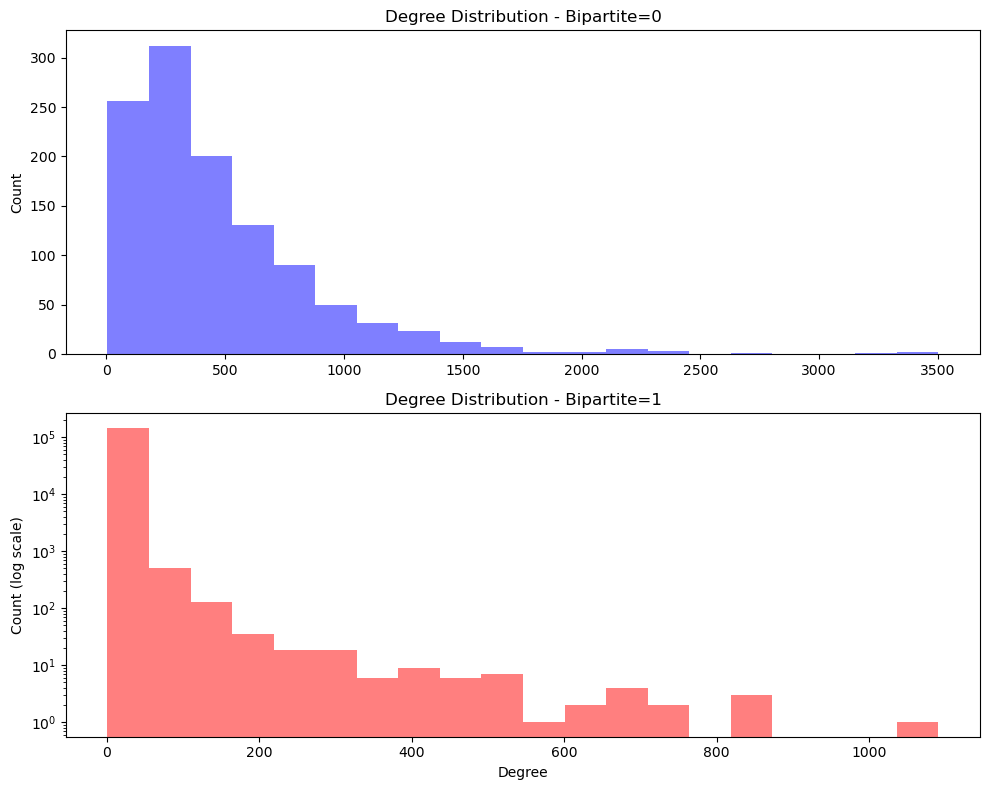

In [26]:
video_ids = set()
commenter_ids = set()
edges = []

for index, row in comments.iterrows():
    v = row['snippet']['videoId']
    c = row['snippet']['topLevelComment']['snippet']['authorDisplayName']
    if v and c:
        video_ids.add(v)
        commenter_ids.add(c)
        edges.append((v, c))
        
print(f"ビデオの数：{len(video_ids)}")
print(f"コメント者の数：{len(commenter_ids)}")

# 2部グラフを作成
B_all = nx.Graph()
B_all.add_nodes_from(video_ids, bipartite=0)  # 動画のIDを1つの集合に割り当てる
B_all.add_nodes_from(commenter_ids, bipartite=1)  # コメント投稿者のIDをもう1つの集合に割り当てる
B_all.add_edges_from(edges) # エッジを追加

# bipartite=0のノードの次数を計算
video_degrees = [degree for _, degree in B_all.degree([node for node, attr in B_all.nodes(data=True) if attr['bipartite'] == 0])]

# bipartite=1のノードの次数を計算
commenter_degrees = [degree for _, degree in B_all.degree([node for node, attr in B_all.nodes(data=True) if attr['bipartite'] == 1])]

# ヒストグラムを作成
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# bipartite=0のヒストグラム
ax1.hist(video_degrees, bins=20, alpha=0.5, color='blue')
ax1.set_ylabel('Count')
ax1.set_title('Degree Distribution - Bipartite=0')

# bipartite=1のヒストグラム
ax2.hist(commenter_degrees, bins=20, alpha=0.5, color='red', log=True)
ax2.set_xlabel('Degree')
ax2.set_ylabel('Count (log scale)')
ax2.set_title('Degree Distribution - Bipartite=1')

plt.tight_layout()
plt.show()

排除するノードの数：145328
残ったノードの数：856


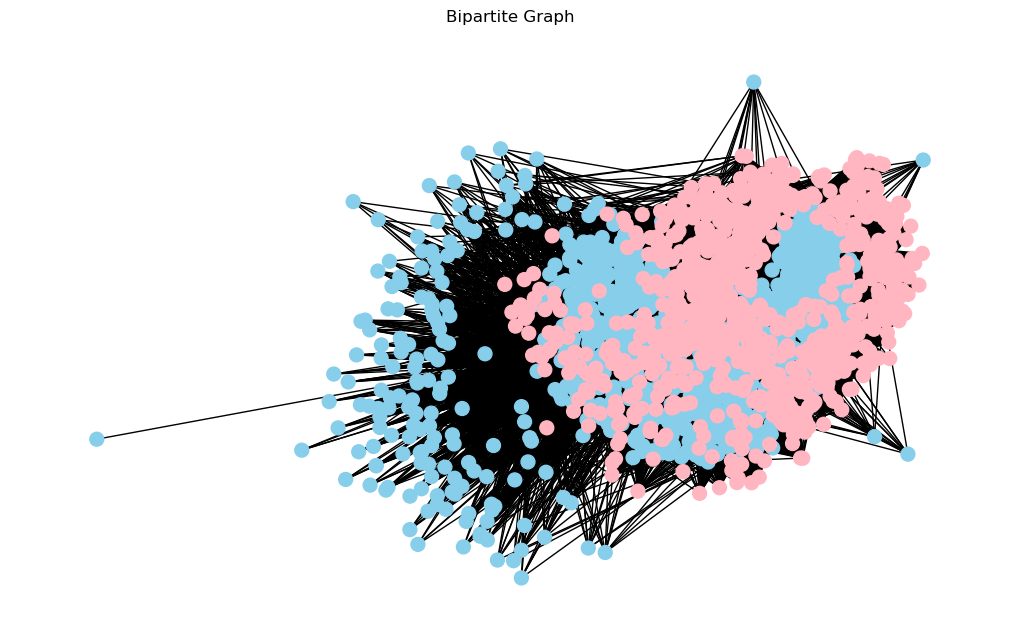

In [27]:
np.random.seed(seed)
B = B_all.copy()

# ノードの次数を計算
node_degrees = B.degree()

# 次数がn以下のbipartite=1のcommenterを削除
n = 50
low_degree_commenter = [node for node, degree in node_degrees if degree <= n and B.nodes[node]['bipartite'] == 1]
print(f"排除するノードの数：{len(low_degree_commenter)}")
print(f"残ったノードの数：{len(commenter_ids)-len(low_degree_commenter)}")
B.remove_nodes_from(low_degree_commenter)

# ノードの色を設定
node_colors = ['skyblue' if node in video_ids else 'lightpink' for node in B.nodes]

# グラフを可視化
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(B, seed=seed)
nx.draw(B, pos, with_labels=False, node_color=node_colors, node_size=100)
plt.title("Bipartite Graph")
plt.show()

Number of communities: 3


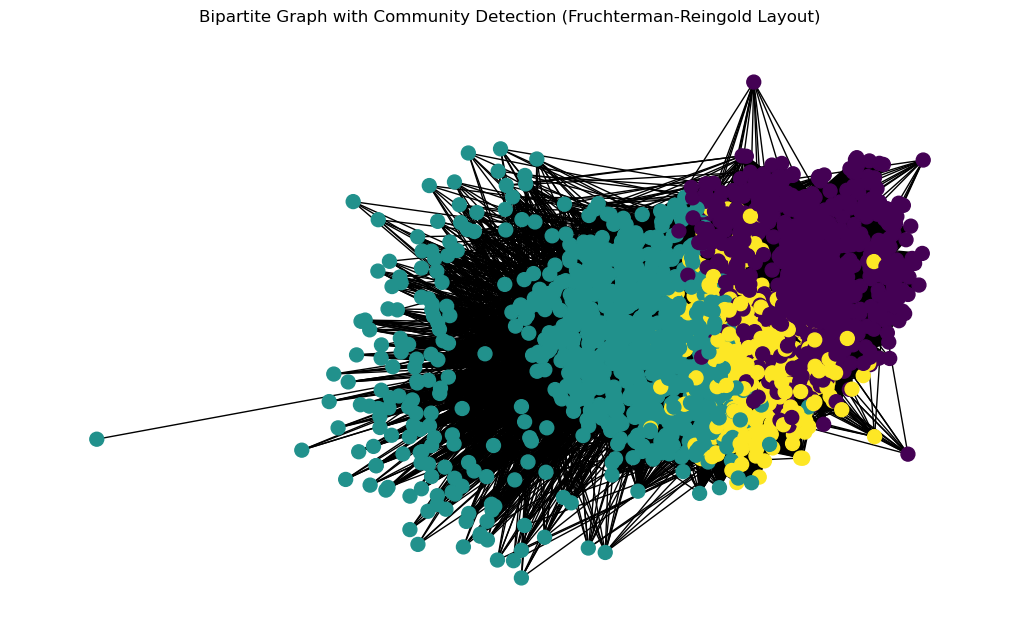

In [28]:
np.random.seed(seed)

# Louvain法でコミュニティを抽出
partition = cl.best_partition(B)

# コミュニティの数を取得
num_communities = max(partition.values()) + 1
print("Number of communities:", num_communities)

# コミュニティごとに色を設定
node_colors = [partition[node] for node in B.nodes]

# フラクタルレイアウトでノードを配置
pos = nx.fruchterman_reingold_layout(B, seed=seed)

# グラフを可視化
plt.figure(figsize=(10, 6))
nx.draw(B, pos, with_labels=False, node_color=node_colors, node_size=100)
plt.title("Bipartite Graph with Community Detection (Fruchterman-Reingold Layout)")
plt.show()

In [ ]:
np.random.seed(seed)

# グラフの特徴量を抽出（例：次数中心性）
node_degrees = nx.degree_centrality(B)

# グラフの特徴量をデータフレームに変換
features = pd.DataFrame.from_dict(node_degrees, orient='index', columns=['degree_centrality'])

# クラスタリング分析を実行
k = 5  # クラスタ数を変更
spectral = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='discretize')
labels = spectral.fit_predict(nx.to_numpy_array(B))

# クラスタごとにノードの色を設定
color_palette = sns.color_palette('husl', n_colors=k)
node_colors = [color_palette[label] for label in labels]

# フラクタルレイアウトでノードを配置
pos = nx.spring_layout(B)

# グラフを可視化
plt.figure(figsize=(10, 6))
nx.draw(B, pos, with_labels=False, node_color=node_colors, node_size=100)
plt.title("Bipartite Graph with Clustering")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
np.random.seed(seed)

# Create your graph
G = B

# Perform community detection using modularity optimization
modularity_communities = greedy_modularity_communities(G)

# Perform community detection using label propagation
label_propagation_communities = label_propagation_communities(G)

# Plot the graph with nodes colored based on the modularity communities
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
colors = [i for i, comm in enumerate(modularity_communities) for _ in comm]
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.get_cmap('tab10'), node_size=200)
nx.draw_networkx_edges(G, pos)
plt.title("Modularity Communities")
plt.show()

# Plot the graph with nodes colored based on the label propagation communities
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
colors = [i for i, comm in enumerate(label_propagation_communities) for _ in comm]
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.get_cmap('tab10'), node_size=200)
nx.draw_networkx_edges(G, pos)
plt.title("Label Propagation Communities")
plt.show()
